[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Practical 1: More dogs and cats!

This time, you are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. You will need to adapt the code from lesson 1 to this new task, i.e. a classification with 37 categories.

##  Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
%matplotlib inline

In [2]:
torch.__version__

'1.6.0'

In [3]:
import sys
sys.version

'3.8.5 (default, Aug  2 2020, 15:09:07) \n[GCC 10.2.0]'

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Downloading the data

The data given on the website [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) is made of two files: `images.tar.gz` and `annotations.tar.gz`. We first need to download and decompress these files.

Depending if you use google colab or your own computer, you can adapt the code below to choose where to store the data.

To see where you are, you can use the standard unix comands:

In [5]:
%pwd

'/home/mlelarge/courses/dataflowr/notebooks/Module1'

If you want to change to a directory to store your data:

In [6]:
%cd /home/mlelarge/
#path

/home/mlelarge


In [7]:
%pwd

'/home/mlelarge'

In [8]:
#%mkdir data
# the line below needs to be adapted if not running on google colab 
%cd ./data/

/home/mlelarge/data


Now that you are in the right directory, you can download the data:

In [ ]:
#!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
#!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

and uncompress it:

In [ ]:
#!tar zxvf images.tar.gz
#!tar zxvf annotations.tar.gz

Check that everything went correctly!

In [9]:
%ls

MNIST/                                        glove.6B.100d.txt
QAP_Regular_ErdosRenyi_1000_50_1.0_0.15_0.2/  glove.6B.200d.txt
__MACOSX/                                     glove.6B.300d.txt
annotations/                                  glove.6B.50d.txt
annotations.tar.gz                            glove.6B.zip
annotations.tar.gz.1                          images/
benchmark_graphs/                             images.tar.gz
challenge/                                    images.tar.gz.1
challenge.tar.gz                              ml-100k/
cifar-10-batches-py/                          ml-100k.zip
cifar-10-python.tar.gz                        ptb.train.txt
data/                                         superpixels/
data.zip                                      test/
dgl_data/                                     train/
dogscats/                                     trainval/
dogscats.tgz


## Warning

If you are running this notebook on your own computer, you need to download the data only once. If you want to run this notebook a second time, you can safely skip this section and the section below as your dataset will be stored nicely on your computer.

If you are running this notebook on google colab, you need to download the data and to do the data wrangling each time you are running this notebook as data will be cleared once you log off.

## 1. Exercise: data wrangling

You will first need to do a bit of [data wrangling](https://en.wikipedia.org/wiki/Data_wrangling) to organize your dataset in order to use the PyTorch `dataloader`.

If you want to understand how the files are organized, have a look at the `README` file in the folder `annotations`.

First, we need to split the dataset in a test set and train/validation set. For this, we can use the files `annotations/test.txt` and `annotations/trainval.txt` containing the names of images contained in the test and train/validation sets of the original paper.

In [10]:
!head annotations/test.txt

Abyssinian_201 1 1 1
Abyssinian_202 1 1 1
Abyssinian_204 1 1 1
Abyssinian_205 1 1 1
Abyssinian_206 1 1 1
Abyssinian_207 1 1 1
Abyssinian_20 1 1 1
Abyssinian_210 1 1 1
Abyssinian_212 1 1 1
Abyssinian_213 1 1 1


In [11]:
!head annotations/trainval.txt

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1


Above you see that the authors of the original paper made a partition of the dataset: `./images/Abyssinian_201.jpg` is in the test set while `./images/Abyssinian_100.jpg` is in the train/validation set and so on.

BTW, it you wonder what Abyssinian means, it is explained [here](https://en.wikipedia.org/wiki/Abyssinian_cat)

We first create two directories where we will put images form the test and trainval sets.

In [12]:
#%mkdir test
#%mkdir trainval

In [14]:
%cd images/

/home/mlelarge/data/images


In [15]:
%ls

Abyssinian_1.jpg*                   english_cocker_spaniel_184.jpg*
Abyssinian_10.jpg*                  english_cocker_spaniel_185.jpg*
Abyssinian_100.jpg*                 english_cocker_spaniel_186.jpg*
Abyssinian_100.mat                  english_cocker_spaniel_187.jpg*
Abyssinian_101.jpg*                 english_cocker_spaniel_188.jpg*
Abyssinian_101.mat                  english_cocker_spaniel_189.jpg*
Abyssinian_102.jpg*                 english_cocker_spaniel_19.jpg*
Abyssinian_102.mat                  english_cocker_spaniel_190.jpg*
Abyssinian_103.jpg*                 english_cocker_spaniel_191.jpg*
Abyssinian_104.jpg*                 english_cocker_spaniel_192.jpg*
Abyssinian_105.jpg*                 english_cocker_spaniel_193.jpg*
Abyssinian_106.jpg*                 english_cocker_spaniel_194.jpg*
Abyssinian_107.jpg*                 english_cocker_spaniel_195.jpg*
Abyssinian_108.jpg*                 english_cocker_spaniel_196.jpg*
Abyssinian_109.jpg*                 english_cocke

Now it's your turn!

All the images are in the `./images/` folder and you want to store the data according to the following structure:
```bash
.
├── test
|   └── Abyssinian # contains images of Abyssinian from the test set
|   └── Bengal # contains images of Bengal from the test set
|    ... 
|   └── american_bulldog # contains images of american bulldog from the test set
|    ...
├── trainval
|   └── Abyssinian # contains images of Abyssinian from the trainval set
|   └── Bengal # contains images of Bengal from the trainval set
|    ...
|   └── american_bulldog # contains images of american bulldog from the trainval set
|    ...
```

Note that all images wiht a name starting with a majuscule is a cat and all images with a name starting with a minuscule is a dog.

So here is one way to achieve your task: you will read the `./annotations/test.txt` file line by line; from each line, you will extract the name of the corresponding file and then copy it from the `./images/filename_##.jpg` to `./test/filename/filename_##.jpg`, where `##` is a number.

Then you'll do the same thing for `trainval.txt` file.

Below is a little piece of code to show you how to open a file and read it line by line:

In [ ]:
with open('./annotations/test.txt') as fp:
    line = fp.readline()
    while line:
        f,_,_,_ = line.split(' ')
        print(f)
        line = fp.readline()
        break

In order to remove the `_201` in the example above, you can use the `re` [regular expression lib](https://docs.python.org/3.6/library/re.html) as follows:

In [ ]:
import re
pat = re.compile(r'_\d')
res,_ = pat.split(f)
print(res)

This small piece of code might be useful:

In [ ]:
# create directory if it does not exist
def check_dir(dir_path):
    dir_path = dir_path.replace('//','/')
    os.makedirs(dir_path, exist_ok=True)

Some more hints:
- for moving files around you can use the `shutil` lib, see [here](https://docs.python.org/3.6/library/shutil.html#shutil.copy)
- you can use `os.path.join`
- have a look at python [f-string](https://cito.github.io/blog/f-strings/)

In [ ]:
import shutil

In [ ]:
# Here your code for test

In [ ]:
# Here your code for train

## Data processing

In [ ]:
%cd ..

Now you are ready to redo what we did during lesson 1.

Below, you give the path where the data is stored. If you are running this code on your computer, you should modifiy this cell.

In [16]:
data_dir = '/home/mlelarge/data/'

`datasets` is a class of the `torchvision` package (see [torchvision.datasets](http://pytorch.org/docs/master/torchvision/datasets.html)) and deals with data loading. It integrates a multi-threaded loader that fetches images from the disk, groups them in mini-batches and serves them continously to the GPU right after each _forward_/_backward_ pass through the network.

Images needs a bit of preparation before passing them throught the network. They need to have all the same size $224\times 224 \times 3$ plus some extra formatting done below by the normalize transform (explained later).

In [17]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

vgg_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

In [18]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), vgg_format)
         for x in ['train', 'test']}

In [19]:
os.path.join(data_dir,'train')

'/home/mlelarge/data/train'

We now have 37 different classes.

In [20]:
dsets['train'].classes

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [21]:
dsets['train'].class_to_idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [22]:
dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
dset_sizes

{'train': 3680, 'test': 3669}

In [23]:
dset_classes = dsets['train'].classes

The `torchvision` packages allows complex pre-processing/transforms of the input data (_e.g._ normalization, cropping, flipping, jittering). A sequence of transforms can be grouped in a pipeline with the help of the `torchvision.transforms.Compose` function, see [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html)

In [24]:
loader_train = torch.utils.data.DataLoader(dsets['train'], batch_size=64, shuffle=True, num_workers=6)#your code here

In [25]:
loader_valid = torch.utils.data.DataLoader(dsets['test'], batch_size=5, shuffle=False, num_workers=6)#your code here

Check your dataloader and everything is doing fine

In [26]:
count = 1
for data in loader_valid:
    print(count, end=',')
    if count == 1:
        inputs_try,labels_try = data
    count += 1

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,

In [27]:
labels_try

tensor([0, 0, 0, 0, 0])

In [28]:
inputs_try.shape

torch.Size([5, 3, 224, 224])

A small function to display images:

In [29]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

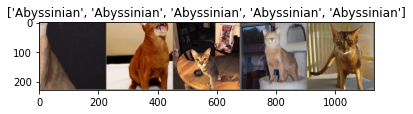

In [30]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

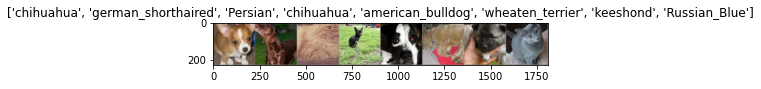

In [31]:
# Get a batch of training data
inputs, classes = next(iter(loader_train))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

## 2. Exercise: modifying VGG Model

The torchvision module comes with a zoo of popular CNN architectures which are already trained on [ImageNet](http://www.image-net.org/) (1.2M training images). When called the first time, if `pretrained=True` the model is fetched over the internet and downloaded to `~/.torch/models`.
For next calls, the model will be directly read from there.

In [32]:
model_vgg = models.vgg16(pretrained=True)#your code here

In [33]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)

model_vgg = model_vgg.to(device)

In [34]:
outputs_try = model_vgg(inputs_try)

In [35]:
outputs_try

tensor([[-2.1273, -1.9013, -1.4397,  ..., -0.2658, -1.3446,  2.5987],
        [-4.2354, -1.2970, -5.2925,  ..., -2.3437,  0.6231,  1.9205],
        [-0.8457,  0.0386, -0.6811,  ..., -1.7113,  1.5666,  1.5187],
        [-0.0458,  0.5761, -0.0371,  ..., -3.4198, -0.2325,  2.0070],
        [-1.2535, -0.2215, -2.0572,  ..., -7.4915,  3.0191,  1.9826]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [36]:
outputs_try.shape

torch.Size([5, 1000])

### Modifying the last layer and setting the gradient false to all layers

In [37]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

![vgg16](https://dataflowr.github.io/notebooks/Module1/img/vgg16.png)

Here, our goal is to use the already trained model and just change the number of output classes. To this end we replace the last ```nn.Linear``` layer trained for 1000 classes to ones with 37 classes. In order to freeze the weights of the other layers during training, we set the field ```required_grad=False```. In this manner no gradient will be computed for them during backprop and hence no update in the weights. Only the weights for the 37-class layer will be updated.

PyTorch documentation for [LogSoftmax](https://pytorch.org/docs/stable/nn.html#logsoftmax)

In [38]:
for param in model_vgg.parameters():
    param.requires_grad = False
# your code here
model_vgg.classifier._modules['6'] = nn.Linear(4096, 37)
model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

In [39]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=37, bias=True)
  (7): LogSoftmax(dim=1)
)


Once you modified the architecture of the network, do not forget to put in onto the device!

In [40]:
model_vgg = model_vgg.to(device)# your code here

## Training fully connected module

### Creating loss function and optimizer

PyTorch documentation for [NLLLoss](https://pytorch.org/docs/stable/nn.html#nllloss) and the [torch.optim module](https://pytorch.org/docs/stable/optim.html#module-torch.optim)

In [41]:
criterion = nn.NLLLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

### Training the model

In [42]:
def train_model(model,dataloader,size,epochs=1,optimizer=None):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in dataloader:
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            loss = criterion(outputs,classes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [43]:
%%time
train_model(model_vgg,loader_train,size=dset_sizes['train'],epochs=2,optimizer=optimizer_vgg)

Loss: 0.0515 Acc: 0.1432
Loss: 0.0380 Acc: 0.4435
CPU times: user 12.1 s, sys: 800 ms, total: 12.9 s
Wall time: 22 s


In [44]:
def test_model(model,dataloader,size):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,37))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    #print(size)
    for inputs,classes in dataloader:
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,classes)           
        _,preds = torch.max(outputs.data,1)
            # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = outputs.data.to('cpu').numpy()
        i += len(classes)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes

In [45]:
predictions, all_proba, all_classes = test_model(model_vgg,loader_valid,size=dset_sizes['test'])

Loss: 0.4014 Acc: 0.7081


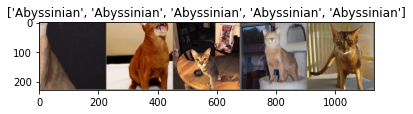

In [46]:
# Get a batch of training data
inputs, classes = next(iter(loader_valid))

out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

Compute the predictions made by your network for `inputs[:n_images]` and the associated probabilities.

Hint: use `torch.max` and `torch.exp`.

Do not forget to put your inputs on the device!

In [47]:
outputs = model_vgg(inputs[:n_images].to(device))
print(torch.exp(outputs))

tensor([[0.0406, 0.0229, 0.0150, 0.0222, 0.0377, 0.0317, 0.0270, 0.0304, 0.0190,
         0.0433, 0.0281, 0.0220, 0.0413, 0.0314, 0.0309, 0.0205, 0.0285, 0.0287,
         0.0210, 0.0204, 0.0293, 0.0333, 0.0259, 0.0148, 0.0264, 0.0205, 0.0268,
         0.0207, 0.0139, 0.0379, 0.0205, 0.0331, 0.0196, 0.0336, 0.0356, 0.0281,
         0.0171],
        [0.0713, 0.0221, 0.0205, 0.0414, 0.0198, 0.0337, 0.0285, 0.0179, 0.0225,
         0.0242, 0.0333, 0.0204, 0.0251, 0.0386, 0.0240, 0.0176, 0.0329, 0.0671,
         0.0247, 0.0192, 0.0183, 0.0122, 0.0205, 0.0159, 0.0133, 0.0271, 0.0536,
         0.0220, 0.0314, 0.0270, 0.0182, 0.0159, 0.0204, 0.0267, 0.0253, 0.0247,
         0.0227],
        [0.0403, 0.0457, 0.0216, 0.0236, 0.0395, 0.0326, 0.0566, 0.0229, 0.0253,
         0.0312, 0.0399, 0.0311, 0.0148, 0.0260, 0.0261, 0.0235, 0.0284, 0.0336,
         0.0183, 0.0265, 0.0365, 0.0164, 0.0229, 0.0192, 0.0217, 0.0193, 0.0393,
         0.0179, 0.0156, 0.0187, 0.0141, 0.0209, 0.0298, 0.0223, 0.0226, 

In [48]:
# your code here
vals_try, preds_try = torch.max(outputs.data,1)# your code here

In [49]:
preds_try

tensor([9, 0, 6, 6, 3], device='cuda:0')

In [50]:
classes[:n_images]

tensor([0, 0, 0, 0, 0])

In [51]:
torch.exp(vals_try)

tensor([0.0433, 0.0713, 0.0566, 0.0622, 0.0754], device='cuda:0')

## Speeding up the learning by precomputing features

In [52]:
def preconvfeat(dataloader):
    conv_features = []
    labels_list = []
    for data in dataloader:
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [53]:
%%time
conv_feat_train,labels_train = preconvfeat(loader_train)

CPU times: user 5.99 s, sys: 548 ms, total: 6.54 s
Wall time: 7.04 s


In [54]:
conv_feat_train.shape

(3680, 512, 7, 7)

In [55]:
%%time
conv_feat_valid,labels_valid = preconvfeat(loader_valid)

CPU times: user 8.12 s, sys: 794 ms, total: 8.92 s
Wall time: 9.2 s


### Creating a new data generator

We will not load images anymore, so we need to build our own data loader.

In [56]:
dtype=torch.float
datasetfeat_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_train,labels_train)]
datasetfeat_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_train]
loaderfeat_train = torch.utils.data.DataLoader(datasetfeat_train, batch_size=128, shuffle=True)

Now you can train for more epochs.

In [57]:
%%time
train_model(model_vgg.classifier,dataloader=loaderfeat_train,size=dset_sizes['train'],epochs=80,optimizer=optimizer_vgg)

Loss: 0.0158 Acc: 0.5815
Loss: 0.0141 Acc: 0.6484
Loss: 0.0128 Acc: 0.6943
Loss: 0.0118 Acc: 0.7193
Loss: 0.0108 Acc: 0.7514
Loss: 0.0102 Acc: 0.7611
Loss: 0.0095 Acc: 0.7736
Loss: 0.0090 Acc: 0.7807
Loss: 0.0087 Acc: 0.7823
Loss: 0.0082 Acc: 0.8057
Loss: 0.0076 Acc: 0.8090
Loss: 0.0075 Acc: 0.8168
Loss: 0.0073 Acc: 0.8209
Loss: 0.0070 Acc: 0.8198
Loss: 0.0069 Acc: 0.8149
Loss: 0.0066 Acc: 0.8280
Loss: 0.0064 Acc: 0.8326
Loss: 0.0062 Acc: 0.8372
Loss: 0.0061 Acc: 0.8380
Loss: 0.0059 Acc: 0.8421
Loss: 0.0058 Acc: 0.8546
Loss: 0.0056 Acc: 0.8486
Loss: 0.0055 Acc: 0.8543
Loss: 0.0054 Acc: 0.8503
Loss: 0.0053 Acc: 0.8492
Loss: 0.0052 Acc: 0.8530
Loss: 0.0051 Acc: 0.8582
Loss: 0.0051 Acc: 0.8592
Loss: 0.0049 Acc: 0.8647
Loss: 0.0049 Acc: 0.8636
Loss: 0.0048 Acc: 0.8617
Loss: 0.0048 Acc: 0.8677
Loss: 0.0046 Acc: 0.8649
Loss: 0.0046 Acc: 0.8717
Loss: 0.0046 Acc: 0.8688
Loss: 0.0045 Acc: 0.8696
Loss: 0.0045 Acc: 0.8649
Loss: 0.0044 Acc: 0.8698
Loss: 0.0044 Acc: 0.8723
Loss: 0.0043 Acc: 0.8693


In [58]:
datasetfeat_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_valid,labels_valid)]
datasetfeat_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_valid]
loaderfeat_valid = torch.utils.data.DataLoader(datasetfeat_valid, batch_size=128, shuffle=False)

Now you can compute the accuracy on the test set.

In [59]:
predictions, all_proba, all_classes = test_model(model_vgg.classifier,dataloader=loaderfeat_valid,size=dset_sizes['test'])

Loss: 0.0035 Acc: 0.8863


## Confusion matrix

For 37 classes, plotting a confusion matrix is useful to see the performance of the algorithm per class.

In [ ]:
#!pip install -U scikit-learn

In [60]:
from sklearn.metrics import confusion_matrix
import itertools
def make_fig_cm(cm):
    fig = plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    tick_marks = np.arange(37);
    plt.xticks(tick_marks, dset_classes, rotation=90);
    plt.yticks(tick_marks, dset_classes, rotation=0);
    plt.tight_layout();
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual');
    plt.xlabel('Predicted');

In [61]:
cm = confusion_matrix(all_classes,predictions)

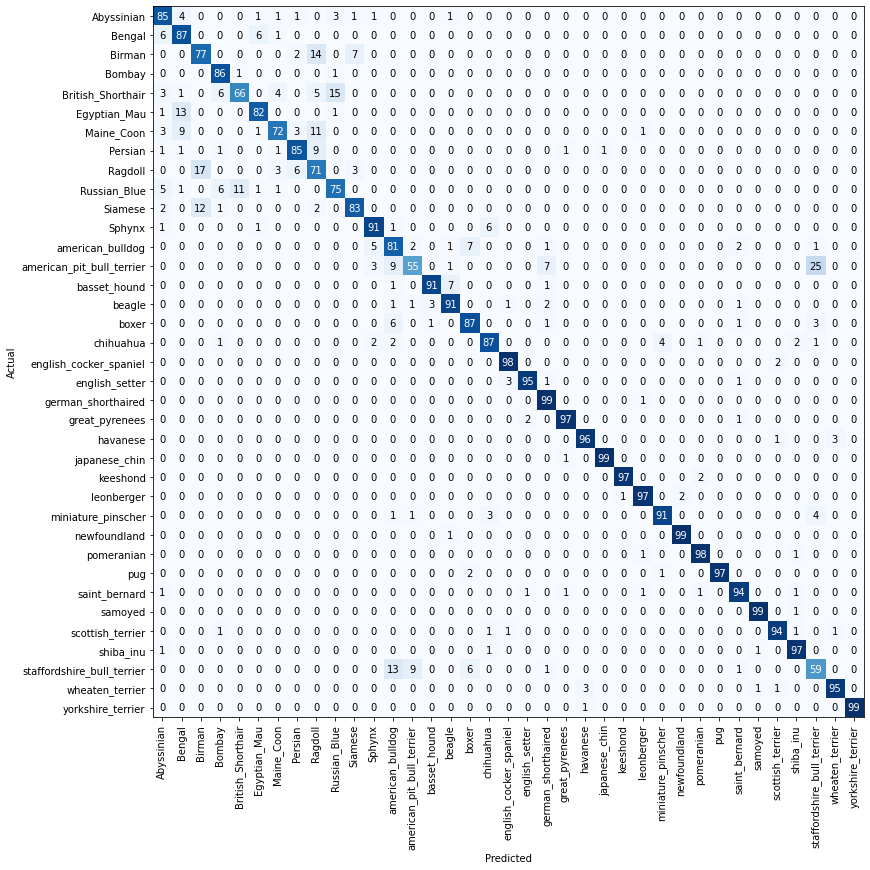

In [62]:
make_fig_cm(cm)

Here, you see that [american pit bull terrier](https://en.wikipedia.org/wiki/American_Pit_Bull_Terrier) are often predicted as [staffordshire bull terrier](https://en.wikipedia.org/wiki/Staffordshire_Bull_Terrier) but overall your algorithm should give pretty good results!

## 3. Exercise: change of neural network model

Great! So far, you reproduced the result of the first lesson. Now, you will need to take another model. I propose to take a `resnet34` from the list availabel [here](https://pytorch.org/docs/stable/torchvision/models.html)

__Note__ the main purpose of this exercise is to lean how to modify a network. We do not really care about performances...

In [ ]:
model_resnet = # your code here

In [ ]:
print(model_resnet)

OK, the strucutre is quite different from the one of VGG we saw during the course but we still see that the last layer is a Linear layer taking a vector of size 512 and producing a vector of size 1000 (i.e. the number of classes in Imagenet). Hence you should be able to modify this network for your classification task with 37 classes!

First freeze the weights of your model and replace the last layer by a Linear layer with the appropriate size.

In [ ]:
# your code here
#Hint print(model_resnet.fc)

Now we need to add the LogSoftmax layer. Follow the instructions [here](https://discuss.pytorch.org/t/how-to-add-an-additional-layer-on-top-of-a-pretrained-model/21303/2) to add this layer

In [ ]:
model_resnet_lsm = # your code here

Check that everything is working fine!

In [ ]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)
model_resnet_lsm = model_resnet_lsm.to(device)
outputs_try = model_resnet_lsm(inputs_try)

In [ ]:
outputs_try.shape

Now you can start training.

You will take the same loss as before: [NLLLoss](https://pytorch.org/docs/stable/nn.html#nllloss) but you need to modify the argument of the optimizer [torch.optim module](https://pytorch.org/docs/stable/optim.html#module-torch.optim)

In [ ]:
#Hint print(model_resnet_lsm[0].fc)
optimizer_resnet = #your code here

Now you can use the same function as above for the training loop.

In [ ]:
%%time
train_model(model_resnet_lsm,loader_train,size=dset_sizes['train'],epochs=30,optimizer=optimizer_resnet)

In [ ]:
%%time
predictions, all_proba, all_classes = test_model(model_resnet_lsm,loader_valid,size=dset_sizes['test'])

In [ ]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

## Well done!

What would you do to speed up the process in the last part?

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)